## Neural Network Prediction

In [1]:
# Imports
import torch
import torch.nn as nn
import pandas as pd
import h3
import datetime as dt
from torch.utils.data import random_split, Dataset, DataLoader
from warnings import filterwarnings
from sklearn.preprocessing import StandardScaler
filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


c:\Users\dawae\miniconda3\envs\AA_Team12\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# this cell converts the raw data into time bucket/hexagon size split data

bike_df = pd.read_csv('data/bike_data.csv', index_col=0)
weather_df = pd.read_csv('data/weather.csv')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)


bike_df['datetime'] = pd.to_datetime(bike_df['datetime'])

# rename weather columns and fill bad data
weather_df = weather_df.fillna(0)
weather_df['datetime'] = pd.to_datetime(
    weather_df['MESS_DATUM'], format='%Y%m%d%H').dt.round(freq='H')
weather_df.loc[weather_df['  R1'] == -999, '  R1'] = 0


weather_df = weather_df[["datetime", "TT_TU",
                         "RF_TU", "   F", "  R1", "SD_SO"]]
weather_df.columns = ["datetime", "temperature",
                      "humidity", "wind", "precipitation", "sun_minutes"]
weather_df["sun_minutes"] = weather_df["sun_minutes"].fillna(0)


# convert raw data into hourly trip data
bike_df_trips = bike_df[['b_number', 'datetime',
                         'trip', 'p_lng', 'p_lat', 'h3index']]
bike_df_trips = bike_df_trips.sort_values('datetime')

bike_df_trips = bike_df_trips.sort_values('datetime')
bike_df_trips = bike_df_trips[bike_df_trips['trip'].isin(['start', 'end'])]

started = False
trips = {'bike_id': [], 'start_time': [], 'end_time': [], 'start_lng': [],
         'start_lat': [], 'end_lng': [], 'end_lat': [], 'start_h3': [], 'end_h3': []}
for i in bike_df_trips['b_number'].unique():
    for _, row in bike_df_trips[bike_df_trips['b_number'] == i].iterrows():
        if not started and row['trip'] == 'start':
            trips['bike_id'].append(row['b_number'])
            trips['start_time'].append(row['datetime'])
            trips['start_lng'].append(row['p_lng'])
            trips['start_lat'].append(row['p_lat'])
            trips['start_h3'].append(row['h3index'])
            started = True
        if started and row['trip'] == 'end':
            trips['end_time'].append(row['datetime'])
            trips['end_lng'].append(row['p_lng'])
            trips['end_lat'].append(row['p_lat'])
            trips['end_h3'].append(row['h3index'])
            started = False
    if started:
        started = False
        del trips['bike_id'][-1]
        del trips['start_time'][-1]
        del trips['start_lng'][-1]
        del trips['start_lat'][-1]
        del trips['start_h3'][-1]

trip_df = pd.DataFrame(trips)

trip_df = trip_df[~(((trip_df.start_lng == trip_df.end_lng) & (trip_df.start_lng == trip_df.end_lng.shift(1)) & (trip_df.end_lng.shift(1) == trip_df.start_lng.shift(1))
                     & (trip_df.start_lng.shift(1) == trip_df.end_lng.shift(2)) & (trip_df.start_lng.shift(2) == trip_df.end_lng.shift(2))
                     & (trip_df.bike_id == trip_df.bike_id.shift(1)) & (trip_df.bike_id.shift(1) == trip_df.bike_id.shift(2))
                     & (trip_df.start_lat == trip_df.end_lat) & (trip_df.start_lat == trip_df.end_lat.shift(1)) & (trip_df.end_lat.shift(1) == trip_df.start_lat.shift(1))
                     & (trip_df.start_lat.shift(1) == trip_df.end_lat.shift(2)) & (trip_df.start_lat.shift(2) == trip_df.end_lat.shift(2))
                     ) |
                    ((trip_df.start_lng == trip_df.end_lng) & (trip_df.end_lng == trip_df.start_lng.shift(-1)) & (trip_df.start_lng.shift(-1) == trip_df.end_lng.shift(-1))
                     & (trip_df.end_lng.shift(-1) == trip_df.start_lng.shift(-2)) & (trip_df.start_lng.shift(-2) == trip_df.end_lng.shift(-2))
                     & (trip_df.bike_id == trip_df.bike_id.shift(-1)) & (trip_df.bike_id.shift(-1) == trip_df.bike_id.shift(-2))
                     & (trip_df.start_lat == trip_df.end_lat) & (trip_df.end_lat == trip_df.start_lat.shift(-1)) & (trip_df.end_lat.shift(-1) == trip_df.start_lat.shift(-1))
                     & (trip_df.end_lat.shift(-1) == trip_df.start_lat.shift(-2)) & (trip_df.start_lat.shift(-2) == trip_df.end_lat.shift(-2))
                     ) |
                    ((trip_df.start_lng == trip_df.end_lng) & (trip_df.end_lng == trip_df.start_lng.shift(-1)) & (trip_df.start_lng.shift(-1) == trip_df.end_lng.shift(-1))
                     & (trip_df.start_lng == trip_df.end_lng.shift(1)) & (trip_df.start_lng.shift(1) == trip_df.end_lng.shift(1))
                     & (trip_df.bike_id == trip_df.bike_id.shift(-1)) & (trip_df.bike_id == trip_df.bike_id.shift(1))
                     & (trip_df.start_lat == trip_df.end_lat) & (trip_df.end_lat == trip_df.start_lat.shift(-1)) & (trip_df.end_lat.shift(-1) == trip_df.start_lat.shift(-1))
                     & (trip_df.start_lat.shift == trip_df.end_lat.shift(1)) & (trip_df.start_lat.shift(1) == trip_df.end_lat.shift(1))
                     ))]

trip_df = trip_df[~((trip_df['start_lng'] == trip_df['end_lng']) & (trip_df['start_lat'] == trip_df['end_lat'])
                    & (trip_df['start_time'] + pd.Timedelta(minutes=3) >= trip_df['end_time']))]

trip_df = trip_df[(
    (trip_df["end_time"]-trip_df["start_time"]).dt.seconds / 60.0) <= 600]


trip_df['month'] = trip_df['start_time'].dt.month
trip_df['weekday'] = trip_df['start_time'].dt.dayofweek
trip_df['dayofyear'] = trip_df['start_time'].dt.dayofyear
trip_df['day'] = trip_df['start_time'].dt.date
trip_df['hour'] = trip_df['start_time'].dt.hour




# this function returns a dataframe that includes the supply at all hexagons for a certain time bucket and hexagon size
def get_availability_df(time_bucket=1, h3_size=6, fill_na=True):
    '''
    Args
    time_bucket: (int) number of hours over which availability is aggregated
    h3_size: (int) h3 resolution on which availability is calculated
    fill_na: (bool) whether to fill time/place combinations not explicitly given

    Returns: df with columns date, h3 index, time bucket index (only if time_bucket > 1), number of available bikes
    '''

    # supply, i.e. availability
    # few hours missing here and in bike demand (< 100), see no benefit in adding
    fill_na = False

    supply_df = bike_df[["p_bikes", "p_booked_bikes", "p_uid",
                         'p_lng', 'p_lat', "datetime", "trip"]][bike_df["p_bikes"] > 0]
    supply_df = supply_df[supply_df["datetime"] <= dt.datetime(2020, 1, 21)]
    supply_df['supply'] = supply_df['p_bikes']
    supply_df["h3index"] = supply_df.apply(
        lambda x: h3.geo_to_h3(x["p_lat"], x["p_lng"], h3_size), axis=1)
    supply_df['datetime'] = supply_df['datetime'].dt.round(freq='H')
    supply_df = supply_df[['datetime', "h3index", 'supply']]

    supply_df = supply_df.groupby(
        ['datetime', 'h3index']).sum().unstack().reset_index()
    supply_df = supply_df.set_index('datetime').sort_index()

    # fill non-visible supply
    # ffill and bfill alone not optimal: trip end --> ffill, start --> bfill appropriate (depending on how bike number defined, potentially reversed)
    # time in between last and first disregarded
    # better solution would require effort
    if fill_na:
        # first bfill --> leaks data, unnecessary: take the last period available anyway
        supply_df = supply_df.fillna(method='ffill')
    supply_df = supply_df.stack().reset_index()

    # weather
    supply_df = supply_df.join(weather_df.set_index('datetime'), on='datetime')
    weather_columns = ["datetime", "temperature",
                       "humidity", "wind", "precipitation", "sun_minutes"]
    supply_df[weather_columns] = supply_df[weather_columns].fillna(0)

    if time_bucket > 1:
        supply_df['hour'] = supply_df['datetime'].dt.hour
        supply_df['datetime'] = pd.to_datetime(supply_df['datetime'].dt.date)
        supply_df['bucket'] = supply_df['hour'].apply(
            lambda x: x // time_bucket)
        supply_df = supply_df.drop('hour', axis=1)
        supply_dfG = supply_df.groupby(
            ['datetime', 'bucket', "h3index"]).mean().reset_index()
        # supply_dfG["supply"] = supply_df.groupby(
        #     ['datetime', 'bucket', "h3index"]).sum().reset_index()["supply"]
        supply_dfG.drop("bucket", axis=1, inplace=True)
        supply_df = supply_dfG

    return supply_df


# this function returns a dataframe that includes the supply at all hexagons for a certain time bucket and hexagon size
def get_demand_df(time_bucket=1, h3_size=6, fill_na=True):
    '''
    Args
    time_bucket: (int) number of hours over which availability is aggregated
    h3_size: (int) h3 resolution on which availability is calculated
    fill_na: (bool) whether to fill time/place combinations not explicitly given

    Returns: df with columns date, h3 index, time bucket index (only if time_bucket > 1), number of available bikes
    '''

    demand_df = trip_df
    demand_df["h3index"] = demand_df.apply(lambda x: h3.geo_to_h3(
        x["start_lat"], x["start_lng"], h3_size), axis=1)
    demand_df['datetime'] = demand_df['start_time'].dt.round(freq='H')
    demand_df = demand_df[['datetime', 'h3index', 'bike_id']]
    demand_df = demand_df.groupby(
        ['datetime', 'h3index']).count().unstack().reset_index()
    demand_df = demand_df.rename({'bike_id': 'demand'}, axis=1)
    demand_df = demand_df.set_index('datetime')

    # fill non-visible demands --> problematic: creates highly unbalanced data
    if fill_na:
        demand_df = demand_df.fillna(0)
    demand_df = demand_df.stack().reset_index()

    # weather
    demand_df = demand_df.join(weather_df.set_index('datetime'), on='datetime')
    weather_columns = ["datetime", "temperature",
                       "humidity", "wind", "precipitation", "sun_minutes"]
    demand_df[weather_columns] = demand_df[weather_columns].fillna(0)

    if time_bucket > 1:
        demand_df['hour'] = demand_df['datetime'].dt.hour
        demand_df['datetime'] = pd.to_datetime(demand_df['datetime'].dt.date)
        demand_df['bucket'] = demand_df['hour'].apply(
            lambda x: x // time_bucket)
        demand_df = demand_df.drop('hour', axis=1)
        demand_dfG = demand_df.groupby(
            ['datetime', 'bucket', 'h3index']).mean().reset_index()
        demand_dfG["demand"] = demand_df.groupby(
            ['datetime', 'bucket', 'h3index']).sum().reset_index()["demand"]
        demand_dfG.drop("bucket", axis=1, inplace=True)
        demand_df = demand_dfG

    return demand_df


In [3]:
# this function creates the dataloaders from the scaled data
def createDL(input_df, label):
    class CustomDataset(Dataset):
        def __init__(self, features, labels):
            self.features = features
            self.labels = labels

        def __len__(self,):
            return len(self.labels)

        def __getitem__(self, index):
            features = torch.tensor(self.features.iloc[index]).float()
            labels = torch.tensor(self.labels.iloc[index]).float()

            return features, labels

    x_train = input_df
    x_train["precipitation"] = x_train["precipitation"].fillna(0)

    demand_df_dataset = CustomDataset(x_train, label)

    # split data into train validation and test set
    # 3 version, because of rounding issues
    try:
        train_data, val, test = random_split(demand_df_dataset, [int(round((len(demand_df_dataset)*0.5))), int(round(
            (len(demand_df_dataset)*0.2))), int(round((len(demand_df_dataset)*0.3)))], generator=torch.Generator().manual_seed(1234))
    except:
        try:
            train_data, val, test = random_split(demand_df_dataset, [int(round((len(demand_df_dataset)*0.5))+1), int(round(
                (len(demand_df_dataset)*0.2))), int(round((len(demand_df_dataset)*0.3)))], generator=torch.Generator().manual_seed(1234))
        except:
            train_data, val, test = random_split(demand_df_dataset, [int(round((len(demand_df_dataset)*0.5))-1), int(round(
                (len(demand_df_dataset)*0.2))), int(round((len(demand_df_dataset)*0.3)))], generator=torch.Generator().manual_seed(1234))

    train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
    val_dl = DataLoader(val, batch_size=64, shuffle=True)
    test_dl = DataLoader(test, batch_size=64, shuffle=True)
    return train_dl, val_dl, test_dl


In [4]:
# this function scales and prepares the data for the dataloader
def scaleDF(df, type):
    input_df = df.copy()
    # shuffle data
    input_df = input_df.sample(frac=1)
    # adjust amount of data used for training
    label = input_df.head(200000)[type]
    input_df = input_df.head(200000)

    input_df["week"] = input_df["datetime"].dt.isocalendar().week
    input_df["hour"] = input_df["datetime"].dt.hour
    input_df["dayofweek"] = input_df["datetime"].dt.dayofweek

    input_df.drop(["datetime", type],
                  axis=1, inplace=True)

    # replace h3 index with unique int id
    input_df["h3ID"] = input_df.h3index.astype(
        'category').cat.rename_categories(range(1, input_df.h3index.nunique()+1))

    # map h3 index to its categorical ID
    h3toID = pd.DataFrame()
    h3toID["h3ID"] = input_df["h3ID"]
    h3toID["h3index"] = input_df["h3index"]
    h3toID = h3toID.groupby('h3ID', as_index=False).first()
    h3toID.set_index("h3ID", inplace=True)
    h3toID = h3toID.to_dict()["h3index"]
    input_df.drop("h3index", axis=1, inplace=True)

    # scale numerical data
    scaler = StandardScaler()
    input_df[["temperature", "humidity", "wind", "precipitation",
              "sun_minutes", "week", "hour", "dayofweek"]] = scaler.fit_transform(input_df[["temperature", "humidity", "wind", "precipitation",
                                                                                            "sun_minutes", "week", "hour", "dayofweek"]])

    return createDL(input_df,  label)


In [5]:
def createTrainNN(epochs, lr, loss_func, train_dl, test_dl, val_dl, hexSize):

    class NeuralNetwork(nn.Module):

        def __init__(self,):
            # this line always has to be at the beginning
            # of a new Module
            super().__init__()
            self.fc1 = nn.Linear(9, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, 1)

        def forward(self, X):
            # We need to bring the data into a format our
            # neural network can handle. Try to understand
            # Pass the input through your layer and add sigmoid activation function
            X = self.fc1(X)
            X = torch.relu(X)
            X = self.fc2(X)
            X = torch.relu(X)
            X = self.fc3(X)
            # X = torch.relu(X)
            X = torch.squeeze(X)
            return X

    # Instantiate the `NeuralNetwork`
    model = NeuralNetwork()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # The training loop should receive the `net`, `train_dl`, `val_dl`, `epochs`, `optimizer`, and `loss_func`.

    def train(model, train_dl, val_dl, epochs, optimizer, loss_func):
        print("epoch | train loss | val loss")
        train_loss = []
        val_loss = []
        prev_train_loss = 1000000000
        prev2 = 10000000000
        for epoch in range(epochs):

            # set model in training state
            model.train()
            total_loss = 0
            for step, (xb, yb) in enumerate(train_dl):
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = loss_func(pred, yb)
                # zero the all gradients
                # calc gradients
                loss.backward()
                # update weights
                optimizer.step()

                optimizer.zero_grad()

                total_loss += loss

            total_loss /= len(train_dl)
            total_loss_val = 0
            model.eval()
            with torch.no_grad():
                for step, (xb_val, yb_val) in enumerate(val_dl):
                    xb_val = xb_val.to(device)
                    yb_val = yb_val.to(device)
                    pred_val = model(xb_val)
                    loss_val = loss_func(pred_val, yb_val)
                    total_loss_val += loss_val
            # Print out the average loss and the accuarcy on both the train and valiadtion data.
            total_loss_val /= len(val_dl)
            print("---------------------------------------------------")
            print(
                f"  {epoch}     |     {total_loss.item():.4f}    |  {total_loss_val.item():.4f}")
            train_loss.append(total_loss.item())
            val_loss.append(total_loss_val.item())
            if prev_train_loss == total_loss.item():
                # often times, this model converges to a bad local optimum immeadiately, which just predicts 0 for everything
                # if this is the case, we just restart the model with lower learning rates
                # until it initializes in a way that does not fall into that optimum
                # can take multiple attempts, depends on the models weight initialization
                print("bad local optimum found, retrying")
                print("new learning rate = " + str(lr/2))
                return -1, -1
            if (prev2/prev_train_loss < 0.99) & (prev_train_loss/total_loss.item() < 0.99):
                # if the learning rate is too high, this can lead to overshooting the target significantly
                # if that happens, try again with smaller lr
                print("overshooting, retrying")
                print("new learning rate = " + str(lr/2))
                return -1, -1
            # if learning for 2 epochs barely changes anything, training stops
            # lower learn limit for smaller h3 sizes, as they tend to improve slower
            if hexSize == 6:
                if (prev2/prev_train_loss < 1.001) & (prev_train_loss/total_loss.item() < 1.001):
                    break
            elif hexSize == 7:
                if (prev2/prev_train_loss < 1.00075) & (prev_train_loss/total_loss.item() < 1.00075):
                    break
            else:
                if (prev2/prev_train_loss < 1.0005) & (prev_train_loss/total_loss.item() < 1.0005):
                    break
            prev2 = prev_train_loss
            prev_train_loss = total_loss.item()

        return train_loss, val_loss

    # Execute the train function and train the model.
    train_loss, val_loss = train(
        model, train_dl, val_dl, epochs, optimizer, loss_func)
    # if training ended in a bad local optimum, it will get retried
    if train_loss == -1:
        return createTrainNN(epochs, lr/2, loss_func, train_dl, test_dl, val_dl, hexSize)

    test_acc = 0
    with torch.no_grad():
        # Perform a prediction on the test set
        for xb_test, yb_test in test_dl:
            xb_test = xb_test.to(device)
            yb_test = yb_test.to(device)
            model.eval()
            pred_test = model(xb_test)  # Forward pass
            acc = loss_func(pred_test, yb_test)
            test_acc += acc

        test_acc /= len(test_dl)

    print(f"Test loss (MSE) is: {test_acc:.2f}")
    return model, test_acc, train_loss, val_loss


In [6]:
from math import sqrt
hexSizes = [6, 7, 8]
timeBuckets = [1, 2, 6, 24]
lrsDemand = [0.001, 0.001, 0.01, 0.01, 0.001, 0.001,
             0.001, 0.001, 0.00001, 0.001, 0.00001, 0.001]
lrsSupply = [0.005, 0.005, 0.00025, 0.005, 0.05, 0.00005,
             0.00005, 0.005, 0.00005, 0.005, 0.05, 0.00005]
models = []
losses = []
train_losses_dem = []
val_losses_dem = []
train_losses_sup = []
val_losses_sup = []
count = 0
for hexSize in hexSizes:
    for timeBucket in timeBuckets:
        print("Hex size " + str(hexSize) +
              " Time bucket "+str(timeBucket) + " demand")
        # get dataframe/dataloaders for the selected time bucket and hexagon size
        demand_df = get_demand_df(timeBucket, hexSize, True)
        train_dl, val_dl, test_dl = scaleDF(demand_df, "demand")
        # training parameters
        # same parameters for all demand predictions, as they perform well for all and the randomness
        # of the network initialization makes a bigger impact in this case
        # upper limit for epochs, will stop earlier if improvements get to small to prevent overfitting
        epochs = 50
        # lr gets reduced automatically if it converges badly
        lr = lrsDemand[count]
        loss_func = nn.MSELoss()
        model, loss, train_loss, val_loss = createTrainNN(
            epochs, lr, loss_func, train_dl, test_dl, val_dl, hexSize)
        models.append(model)

        # add losses to lists for plotting
        # MSE/mean demand
        losses.append(sqrt(loss.item())/demand_df["demand"].mean())
        train_losses_dem.append(
            [sqrt(x) / demand_df["demand"].mean() for x in train_loss])
        val_losses_dem.append(
            [sqrt(x) / demand_df["demand"].mean() for x in val_loss])

        print("Hex size " + str(hexSize) +
              " Time bucket "+str(timeBucket) + " supply")
        # get dataframe/dataloaders for the selected time bucket and hexagon size
        availability_df = get_availability_df(timeBucket, hexSize, True)
        train_dl, val_dl, test_dl = scaleDF(availability_df, "supply")
        # training parameters
        # same parameters for all supply predictions, as they perform well for all and the randomness
        # of the network initialization makes a bigger impact in this case
        # upper limit for epochs, will stop earlier if improvements get to small to prevent overfitting
        epochs = 50
        # lr gets reduced automatically if it converges badly
        lr = lrsSupply[count]
        loss_func = nn.MSELoss()
        model, loss, train_loss, val_loss = createTrainNN(
            epochs, lr, loss_func, train_dl, test_dl, val_dl, hexSize)
        models.append(model)

        # add losses to lists for plotting
        # MSE/mean supply
        losses.append(sqrt(loss.item())/availability_df["supply"].mean())
        train_losses_sup.append(
            [sqrt(x) / availability_df["supply"].mean() for x in train_loss])
        val_losses_sup.append(
            [sqrt(x) / availability_df["supply"].mean() for x in val_loss])
        count += 1


Hex size 6 Time bucket 1 demand
epoch | train loss | val loss
---------------------------------------------------
  0     |     70.6023    |  66.4370
---------------------------------------------------
  1     |     64.4073    |  61.8794
---------------------------------------------------
  2     |     59.7915    |  56.4565
---------------------------------------------------
  3     |     54.3321    |  52.3766
---------------------------------------------------
  4     |     49.2475    |  45.1016
---------------------------------------------------
  5     |     45.1054    |  42.1706
---------------------------------------------------
  6     |     41.5605    |  38.3349
---------------------------------------------------
  7     |     38.9446    |  47.9326
---------------------------------------------------
  8     |     36.4024    |  39.7997
---------------------------------------------------
  9     |     34.6788    |  32.3115
---------------------------------------------------
  10  

In [7]:
names = []
for hexSize in hexSizes:
    for timeBucket in timeBuckets:
        names.append("h3=" + str(hexSize))


In [14]:
trL = pd.DataFrame(val_losses_dem)
# if local optimum is found, training stops so error is same for all after
# trL = trL.fillna(axis=1, method='ffill')
trL.index = names

trLS = pd.DataFrame(val_losses_sup)
# if local optimum is found, training stops so error is same for all after
# trLS = trLS.fillna(axis=1, method='ffill')
trLS.index = names


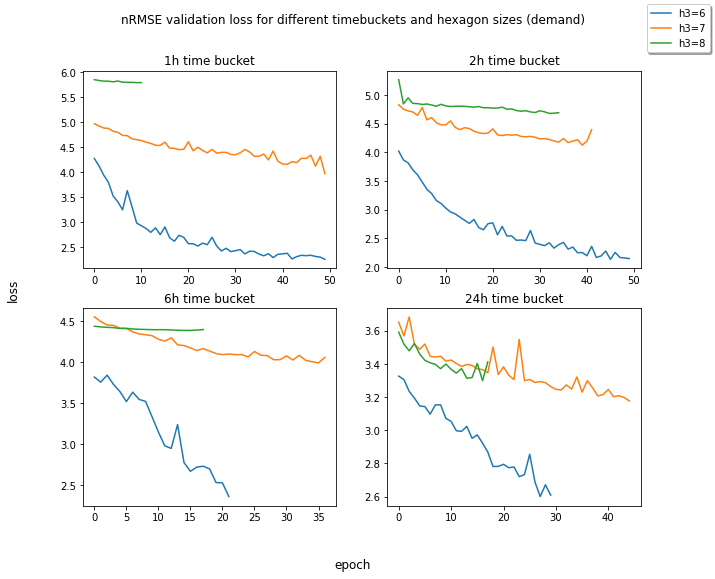

In [17]:
# Please note that this plot does not scale dynamically, if more/fewer timebuckets are used, this will not work
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

fig.suptitle(
    "nRMSE validation loss for different timebuckets and hexagon sizes (demand)")
fig.supxlabel("epoch")
fig.supylabel("loss")


l1 = axs[0, 0].plot(trL[::len(timeBuckets)].T)
axs[0, 0].set(title=str(timeBuckets[0])+'h time bucket')

l2 = axs[0, 1].plot(trL[1::len(timeBuckets)].T)
axs[0, 1].set(title=str(timeBuckets[1])+'h time bucket')

l3 = axs[1, 0].plot(trL[2::len(timeBuckets)].T)
axs[1, 0].set(title=str(timeBuckets[2])+'h time bucket')

l4 = axs[1, 1].plot(trL[3::len(timeBuckets)].T)
axs[1, 1].set(title=str(timeBuckets[3])+'h time bucket')

fig.legend([l1, l2, l3, l4], labels=names[::len(
    timeBuckets)], shadow=True, fancybox=True)

plt.show()


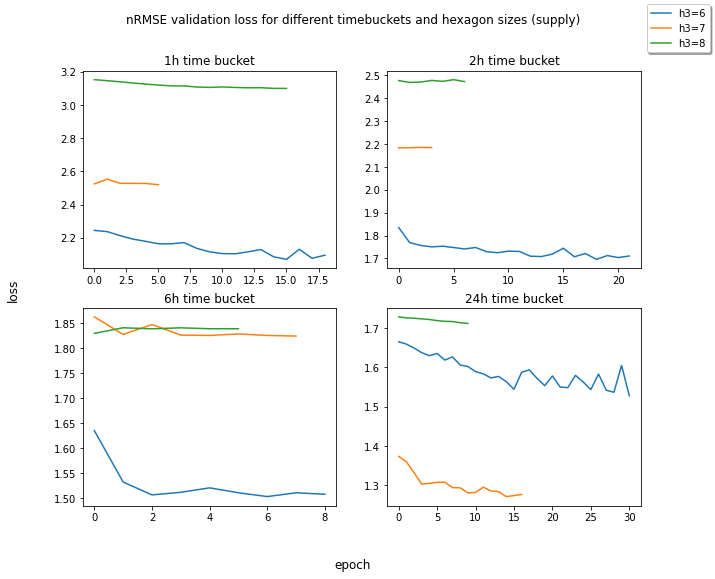

In [18]:
# Please note that this plot does not scale dynamically, if more/fewer timebuckets are used, this will not work
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

fig.suptitle(
    "nRMSE validation loss for different timebuckets and hexagon sizes (supply)")
fig.supxlabel("epoch")
fig.supylabel("loss")


l1 = axs[0, 0].plot(trLS[::len(timeBuckets)].T)
axs[0, 0].set(title=str(timeBuckets[0])+'h time bucket')

l2 = axs[0, 1].plot(trLS[1::len(timeBuckets)].T)
axs[0, 1].set(title=str(timeBuckets[1])+'h time bucket')

l3 = axs[1, 0].plot(trLS[2::len(timeBuckets)].T)
axs[1, 0].set(title=str(timeBuckets[2])+'h time bucket')

l4 = axs[1, 1].plot(trLS[3::len(timeBuckets)].T)
axs[1, 1].set(title=str(timeBuckets[3])+'h time bucket')

fig.legend([l1, l2, l3, l4], labels=names[::len(
    timeBuckets)], shadow=True, fancybox=True)

plt.show()


In [21]:
# this function predicts demand/supply
def prediction(timestamp, temperature,humidity,wind, precipitation, sun_minutes,model,demandOrSupply):
    week = timestamp.isocalendar().week
    hour = timestamp.hour
    dayofweek = timestamp.weekday()
    scaler = StandardScaler()
    temp=pd.DataFrame(data=[[temperature, humidity, wind, precipitation, sun_minutes, week, hour, dayofweek]],columns=[["temperature", "humidity", "wind", "precipitation", "sun_minutes", "week", "hour", "dayofweek"]])
    output=pd.DataFrame(columns=[["h3index","output"]])
    if demandOrSupply==0:
        demand_df=get_demand_df(tb,h3Size,True)
    else:
        demand_df=get_availability_df(tb,h3Size,True)
    hexs=demand_df.h3index.astype(
        'category').cat.rename_categories(range(1, demand_df.h3index.nunique()+1))
    h3toID = pd.DataFrame()
    h3toID["h3ID"] = hexs
    h3toID["h3index"] = demand_df["h3index"]
    h3toID = h3toID.groupby('h3ID', as_index=False).first()
    h3toID.set_index("h3ID", inplace=True)
    h3toID = h3toID.to_dict()["h3index"]
    for h3index in hexs.unique():
        temp[["temperature", "humidity", "wind", "precipitation", "sun_minutes", "week", "hour", "dayofweek"]]=scaler.fit_transform(temp[["temperature", "humidity", "wind", "precipitation", "sun_minutes", "week", "hour", "dayofweek"]])
        temp["h3index"]=h3index
        tens=torch.tensor(temp.iloc[0]).float()
        tens=tens.to(device)
        output.loc[len(output)]=[h3index,model(tens).item()]
    output["h3index"]=output["h3index"].replace(h3toID)
    return output
  

In [24]:
# predict demand/supply for all h3 indexes given a certain time and weather

# change paramters here
tb = 24
h3Size = 7
# 1 if supply, 0 if demand
demandOrSupply = 1
timestamp = dt.datetime(2019, 7, 7, 10)
temperature = 20
humidity = 1
wind = 1
precipitation = 0
sun_minutes = 50

# do not change
model = models[2*(timeBuckets.index(tb)+len(timeBuckets)
                  * hexSizes.index(h3Size))+demandOrSupply]
out = prediction(timestamp, temperature, humidity, wind,
                 precipitation, sun_minutes, model,demandOrSupply)
out


h3index     output
0    871e247b0ffffff  18.456524
1    871f1b090ffffff  25.920973
2    871f1b091ffffff  25.667082
3    871f1b092ffffff  25.419916
4    871f1b093ffffff  25.173002
5    871f1b096ffffff  24.444086
6    871f1b460ffffff  19.694265
7    871f1b461ffffff  19.640888
8    871f1b463ffffff  19.550764
9    871f1b464ffffff  19.504396
10   871f1b465ffffff  19.462587
11   871f1b466ffffff  19.420778
12   871f1b468ffffff  19.378969
13   871f1b469ffffff  19.337160
14   871f1b46bffffff  19.253540
15   871f1b46cffffff  19.212009
16   871f1b475ffffff  18.964581
17   871f1b541ffffff  18.679079
18   871f1b548ffffff  18.650053
19   871f1b549ffffff  18.652302
20   871f1b54affffff  18.654549
21   871f1b54bffffff  18.656796
22   871f1b559ffffff  18.695522
23   871f1b55dffffff  18.823978
24   871f1b54effffff  18.663538
25   871f1a8d9ffffff  27.354994
26   871f1b46effffff  19.129534
27   871f1b0b6ffffff  22.044703
28   871f1b0b4ffffff  22.523333
29   871f1b448ffffff  20.164434
30   871f1b462ffffff  19.595047
31   871f1b54cffffff  18.659044
32   871e34b6effffff  21.993540
33   871f1b458ffffff  19.810526
34   871f1b54dffffff  18.661291
35   871f1b558ffffff  18.681648
36   871f1b543ffffff  18.651791
37   871ea5301ffffff  25.766691
38   871f1b46affffff  19.295349
39   871f1b445ffffff  20.223989
40   871f1b0b2ffffff  23.002798
41   872b8d096ffffff  21.773693
42   871f1b540ffffff  18.702957
43   871f1b46dffffff  19.170771
44   871f1b55bffffff  18.739849
45   871f1b714ffffff  20.042984
46   871f1b710ffffff  19.909681
47   871f1b0b0ffffff  23.242445
48   871f1b441ffffff  20.377340
49   871f1b44dffffff  19.987406
50   871f1b094ffffff  24.929010
51   871f1bcd1ffffff  21.042763
52   871f1b02effffff  27.071531
53   871f1b569ffffff  19.040356
54   871e34a6dffffff  20.203812
55   871f1b544ffffff  18.643311
56   871f1b192ffffff  21.805571
57   871f1b474ffffff  19.005819
58   871f1b4c1ffffff  18.804974
59   871f1b45cffffff  19.751566
60   871f1b545ffffff  18.645559
61   871f1b736ffffff  20.642851
62   871f1b0b5ffffff  22.283884
63   871f1b56affffff  19.086264
64   871f1b198ffffff  21.389900
65   871f1b449ffffff  20.105326
66   871f1b024ffffff  27.212831
67   871f1b193ffffff  21.577906
68   871f1b715ffffff  20.109636
69   871f1b571ffffff  19.269897
70   871f1bcdaffffff  21.176065
71   871f1b56cffffff  19.178082
72   871e35918ffffff  23.294502
73   871f1b471ffffff  19.047056
74   871fac18cffffff  21.508795
75   871fac18effffff  21.575018
76   871fac19dffffff  21.641245
77   871f1b70affffff  19.843027
78   871f1b71cffffff  20.309591
79   871f1b476ffffff  18.923342
80   871fac183ffffff  21.442568
81   871f1bcf0ffffff  21.242718
82   871f1ba90ffffff  20.909458
83   871f1bcd9ffffff  21.109413
84   871f1b6a4ffffff  19.709724
85   871f1b086ffffff  26.215307
86   871f1b55effffff  18.866043
87   871f1b082ffffff  26.912537
88   871f1b4e1ffffff  18.784571
89   871f1b4e5ffffff  18.764168
90   871f1b4f6ffffff  18.723360
91   871f1b44cffffff  20.046366
92   871f1b575ffffff  19.376467
93   871f1b71dffffff  20.376244
94   871f1b7a4ffffff  20.776155
95   871f1b732ffffff  20.509546
96   871f1b09cffffff  23.721786
97   871f1bc6affffff  20.976110
98   871f1b0b3ffffff  22.763067
99   871f1b555ffffff  18.670891
100  871f1b55cffffff  18.781914
101  871f1b56effffff  19.223989
102  871f1b626ffffff  19.576420
103  871f1b716ffffff  20.176289
104  871f1b562ffffff  18.950174
105  871f1b56bffffff  19.132172
106  871f1b488ffffff  18.882105
107  871f1b568ffffff  18.994446
108  871f8d7a4ffffff  21.376020
109  871f1b095ffffff  24.685919
110  871f1b62effffff  19.643074
111  871f1b09effffff  23.482094
112  871f1b42affffff  20.684605
113  871f1b42dffffff  20.582182
114  871f1b084ffffff  26.631384
115  871f1b561ffffff  18.908110
116  871f1b444ffffff  20.289934
117  871f186b0ffffff  26.310209
118  871f186b5ffffff  26.817354
119  871f1b720ffffff  20.442896
120  871f1b44effffff  19.928446
121  871f1b8c4ffffff  20.842806
122  871f186b6ffffff  27.143606
123  871f1b40bffffff  21.048466
124  87b2c554